Support Vector Machine(One vs Rest)
--------------
Στον παρκάτω κώδικα υλοποιήσαμε έναν γραμμικό SVM ταξινομητή και τον επεκτείναμε σε πολυκλασικό πρόβλημα με τη στρατηγική One-vs-Rest, χρησιμοποιώντας το Wine dataset. Αρχικά φορτώσαμε τα δεδομένα, τα χωρίσαμε σε σύνολα εκπαίδευσης και ελέγχου και τα κανονικοποιήσαμε με StandardScaler. Στη συνέχεια υλοποιήσαμε τον δυαδικό SVM με hinge loss και L2 regularization, εκπαιδεύοντας τα βάρη μέσω gradient descent. Για τo multiclass classification εκπαιδεύσαμε έναν SVM για κάθε κλάση έναντι των υπολοίπων(One vs Rest) και επιλέξαμε την τελική πρόβλεψη με βάση τη μέγιστη τιμή της συνάρτησης απόφασης. Αξιολογήσαμε το μοντέλο με accuracy και classification report, οπτικοποιήσαμε τα αποτελέσματα με PCA, και τέλος συγκρίναμε την απόδοσή μας με την υλοποίηση LinearSVC του sklearn για επιβεβαίωση της ορθότητας.




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found in: /content/drive/MyDrive/wine_dataset.csv
Training SVM for Class 0 vs Rest...
Training SVM for Class 1 vs Rest...
Training SVM for Class 2 vs Rest...

SVM One-vs-Rest Results:
------------------------------
Accuracy: 1.0000 (100.00%)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg    

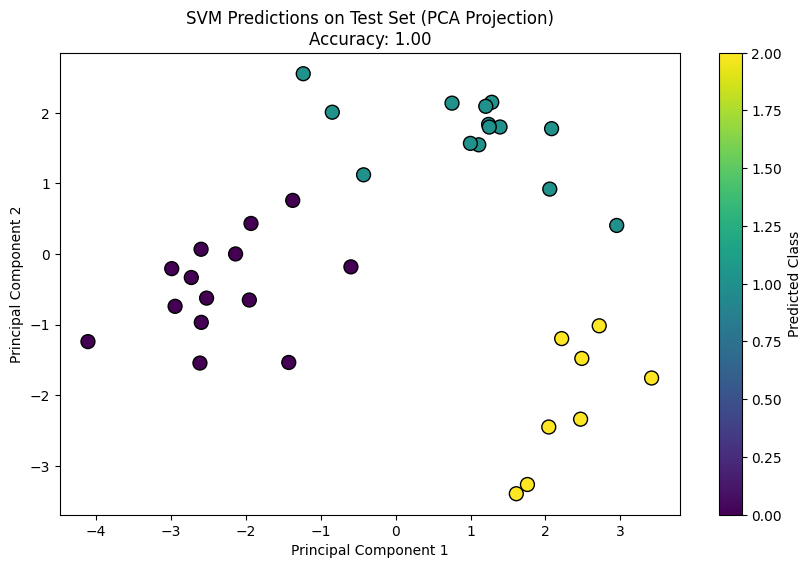


------
Custom SVM Accuracy: 1.0000
Sklearn SVM Accuracy: 1.0000


In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')

import sys
import importlib.util
sys.path.append("/content/drive/MyDrive/machine learning")

pca_path = "/content/drive/MyDrive/machine learning/PCA.py"
spec = importlib.util.spec_from_file_location("PCA_module", pca_path)
PCA_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(PCA_module)

PCA = PCA_module.PCA


from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from google.colab import drive



# ---------------------------------------------------------
#LOAD
# ---------------------------------------------------------

drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

file_path = '/content/drive/MyDrive/wine_dataset.csv'

if not os.path.exists(file_path):
    print("File is not in Drive. Importing from sklearn...")
    raw_data = load_wine()
    df = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
    df['target'] = raw_data.target
    df.to_csv(file_path, index=False)
    print(f"Dataset saved in: {file_path}")
else:
    print(f"File found in: {file_path}")

df = pd.read_csv(file_path)


X = df.drop('target', axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




# -------------------------------------------
# ------------------SVM----------------------
# -------------------------------------------

class SVM:

  def __init__(self,learning_rate=0.001,lambda_param=0.01,n_iters=1000):
    self.lr = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters
    self.w = None
    self.b = None

  def fit(self,x,y):
    n_samples,n_features = x.shape

    y_ = np.where(y<=0,-1,1)

    self.w = np.zeros(n_features)
    self.b = 0

    for _ in range(self.n_iters):
      for idx,x_i in enumerate(x):
        condition = y_[idx] *  (np.dot(x_i,self.w)- self.b) >= 1
        if condition:
          self.w -= self.lr * (2 * self.lambda_param * self.w)
        else:
          self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i,y_[idx]))
          self.b -= self.lr * y_[idx]

  def decision_function(self, X):
        return np.dot(X, self.w) - self.b


  def predict(self,x):
    approx = np.dot(x,self.w) - self.b
    return np.sign(approx)



# ---------------------------------------------------------
#ONE-VS-REST SVM
# ---------------------------------------------------------
class OneVsRestSVM:
    def __init__(self, n_classes, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.n_classes = n_classes
        self.models = []
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters

    def fit(self, X, y):
        #for each class (0, 1, 2) we train an SVM
        for class_idx in range(self.n_classes):
            print(f"Training SVM for Class {class_idx} vs Rest...")

            #1 this class, -1 other class
            y_binary = np.where(y == class_idx, 1, -1)

            #train Binary SVM
            clf = SVM(learning_rate=self.lr, lambda_param=self.lambda_param, n_iters=self.n_iters)
            clf.fit(X, y_binary)

            #save
            self.models.append(clf)

    def predict(self, X):
        scores = np.zeros((X.shape[0], self.n_classes))

        #score from each SVM
        for class_idx, clf in enumerate(self.models):
            scores[:, class_idx] = clf.decision_function(X)

        #for each sample ,prediction is the class with the highest score (argmax)
        return np.argmax(scores, axis=1)



# ---------------------------------------------------------
#Execution and evaluation
# ---------------------------------------------------------

# Multiclass SVM (3 classes)
model = OneVsRestSVM(n_classes=3, learning_rate=0.001, lambda_param=0.01, n_iters=2000)

#train
model.fit(X_train, y_train)

#prediction
predictions = model.predict(X_test)

#results
print("\nSVM One-vs-Rest Results:")
print("-" * 30)
acc = accuracy_score(y_test, predictions)
print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, predictions))



# ---------------------------------------------------------
#VISUALIZATION
# ---------------------------------------------------------

#features are 13 and we cannot draw lines->PCA to show results
pca = PCA(k=2)
X_test_pca = pca.fit_transform(X_test)


plt.figure(figsize=(10, 6))

plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=predictions, cmap='viridis', s=100, edgecolor='k')
plt.title(f'SVM Predictions on Test Set (PCA Projection)\nAccuracy: {acc:.2f}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Predicted Class')
plt.show()



# SKLEARN Check ---
from sklearn.svm import LinearSVC

print("\n------")

print(f"Custom SVM Accuracy: {acc:.4f}")

# One-vs-Rest (ovr)->  default LinearSVC
sklearn_model = LinearSVC(dual="auto", max_iter=2000, C=1.0)
sklearn_model.fit(X_train, y_train)
sklearn_acc = accuracy_score(y_test, sklearn_model.predict(X_test))

print(f"Sklearn SVM Accuracy: {sklearn_acc:.4f}")
